<a href="https://colab.research.google.com/github/KevinTheRainmaker/Speech_Emotion_Classifier/blob/main/SpeechEmotionClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [163]:
import pandas as pd
import numpy as np

import os
import sys

# to analyze audio
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

from tqdm import tqdm

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [79]:
# mount gdrive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

path = '/content/drive/MyDrive/data/emotional_speech'

Mounted at /content/drive


In [80]:
# paths
crema = os.path.join(path, "CREMA-D")
savee = os.path.join(path, "SAVEE")
ravdess = os.path.join(path, "RAVDESS")
tess = os.path.join(path, "TESS")

## Data Preperation

### 1. CREMA Dataframe

In [81]:
crema_directory_list = os.listdir(crema)

In [82]:
file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(crema + '/' + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

In [83]:
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
emotion_df.head()

,Emotions
0,sad
1,sad
2,fear
3,sad
4,disgust


In [84]:
# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
crema_df = pd.concat([emotion_df, path_df], axis=1)
crema_df.head()

,Emotions,Path
0,sad,/content/drive/MyDrive/data/emotional_speech/C...
1,sad,/content/drive/MyDrive/data/emotional_speech/C...
2,fear,/content/drive/MyDrive/data/emotional_speech/C...
3,sad,/content/drive/MyDrive/data/emotional_speech/C...
4,disgust,/content/drive/MyDrive/data/emotional_speech/C...


### 2. SAVEE Dataset

In [85]:
savee_directory_list = os.listdir(savee)

In [87]:
file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(savee + '/' + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')

In [88]:
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
emotion_df.head()

,Emotions
0,neutral
1,surprise
2,neutral
3,sad
4,sad


In [89]:
path_df = pd.DataFrame(file_path, columns=['Path'])
savee_df = pd.concat([emotion_df, path_df], axis=1)
savee_df.head()

,Emotions,Path
0,neutral,/content/drive/MyDrive/data/emotional_speech/S...
1,surprise,/content/drive/MyDrive/data/emotional_speech/S...
2,neutral,/content/drive/MyDrive/data/emotional_speech/S...
3,sad,/content/drive/MyDrive/data/emotional_speech/S...
4,sad,/content/drive/MyDrive/data/emotional_speech/S...


### 3. RAVDESS Dataframe

**Filename identifiers**

- Modality (01 = full-AV, 02 = video-only, 03 = audio-only).

- Vocal channel (01 = speech, 02 = song).

- Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

- Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

- Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").

- Repetition (01 = 1st repetition, 02 = 2nd repetition).

- Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

In [90]:
ravdess_directory_list = os.listdir(ravdess)

In [91]:
file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    actor = os.listdir(ravdess + '/' + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # print(part[2])
        file_emotion.append(int(part[2]))
        file_path.append(ravdess + '/' + dir + '/' + file)

In [92]:
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
emotion_df.head()

,Emotions
0,7
1,4
2,8
3,8
4,4


In [93]:
path_df = pd.DataFrame(file_path, columns=['Path'])
ravdess_df = pd.concat([emotion_df, path_df], axis=1)
ravdess_df.head()

,Emotions,Path
0,7,/content/drive/MyDrive/data/emotional_speech/R...
1,4,/content/drive/MyDrive/data/emotional_speech/R...
2,8,/content/drive/MyDrive/data/emotional_speech/R...
3,8,/content/drive/MyDrive/data/emotional_speech/R...
4,4,/content/drive/MyDrive/data/emotional_speech/R...


In [94]:
# changing integers to actual emotions.
ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
ravdess_df.head()

,Emotions,Path
0,disgust,/content/drive/MyDrive/data/emotional_speech/R...
1,sad,/content/drive/MyDrive/data/emotional_speech/R...
2,surprise,/content/drive/MyDrive/data/emotional_speech/R...
3,surprise,/content/drive/MyDrive/data/emotional_speech/R...
4,sad,/content/drive/MyDrive/data/emotional_speech/R...


### 4. TESS Dataset

In [95]:
tess_directory_list = os.listdir(tess)

In [96]:
file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(tess + '/' + dir)
    # print(directories)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(tess + '/' + dir + '/' + file)

In [97]:
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
emotion_df.head()

,Emotions
0,sad
1,sad
2,sad
3,sad
4,sad


In [98]:
path_df = pd.DataFrame(file_path, columns=['Path'])
tess_df = pd.concat([emotion_df, path_df], axis=1)
tess_df.head()

,Emotions,Path
0,sad,/content/drive/MyDrive/data/emotional_speech/T...
1,sad,/content/drive/MyDrive/data/emotional_speech/T...
2,sad,/content/drive/MyDrive/data/emotional_speech/T...
3,sad,/content/drive/MyDrive/data/emotional_speech/T...
4,sad,/content/drive/MyDrive/data/emotional_speech/T...


In [99]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([ravdess_df, crema_df, tess_df, savee_df], axis = 0)
data_path.to_csv(os.path.join(path, "data_path.csv"),index=False)
data_path.head()

,Emotions,Path
0,disgust,/content/drive/MyDrive/data/emotional_speech/R...
1,sad,/content/drive/MyDrive/data/emotional_speech/R...
2,surprise,/content/drive/MyDrive/data/emotional_speech/R...
3,surprise,/content/drive/MyDrive/data/emotional_speech/R...
4,sad,/content/drive/MyDrive/data/emotional_speech/R...


## Data Visualization

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


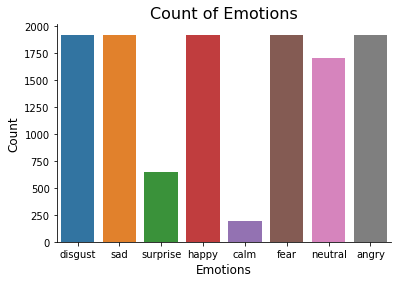

In [100]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [101]:
# waveplot: loudness of the audio
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

# spectrogram: frequencies changing with respect to time for the audio
def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

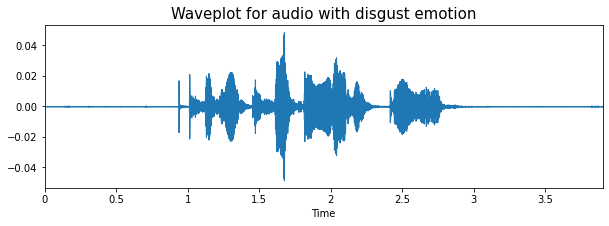

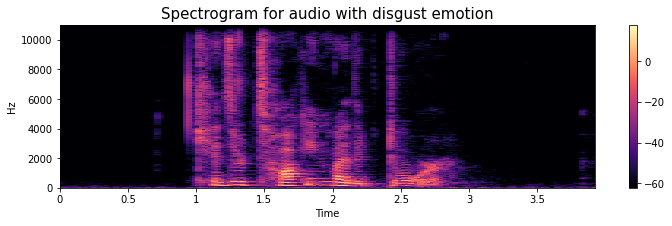

In [121]:
emotion = 'disgust'
path = np.array(data_path.Path[data_path.Emotions==emotion])[5]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## Data Augmentation

In [147]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-7, high = 7)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.8):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [148]:
# testing augmentation
path = np.array(data_path.Path)[0]
data, sample_rate = librosa.load(path)

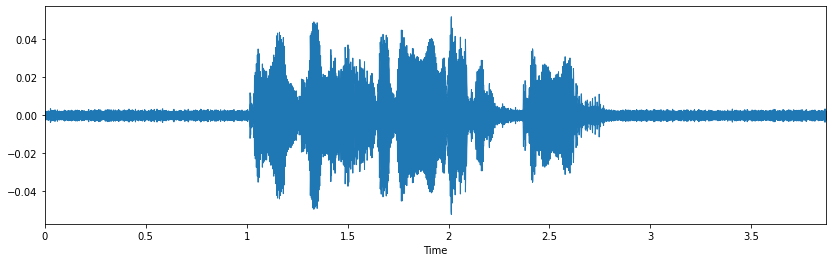

In [149]:
# noise injection
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

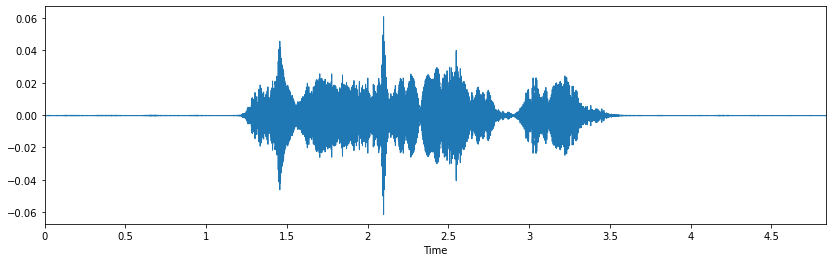

In [150]:
# stretching
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

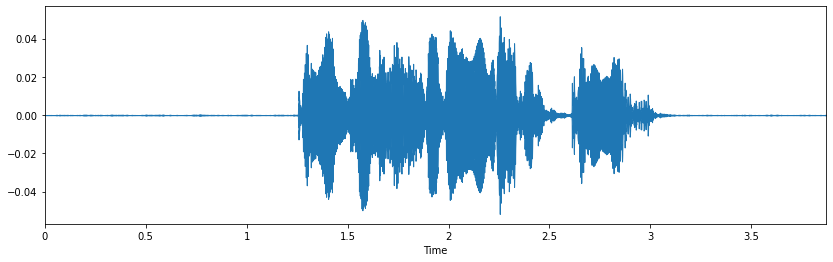

In [151]:
# shifting
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

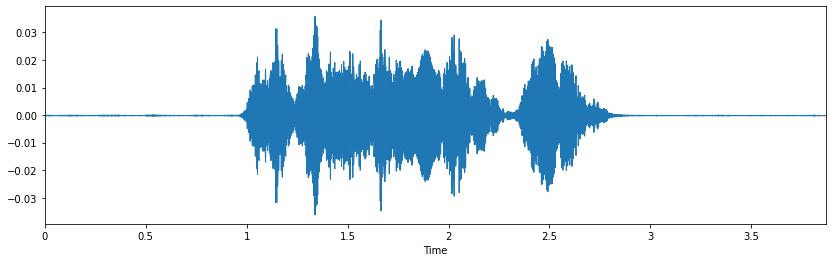

In [152]:
# pitching
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

## Feature Extraction

- Zero Crossing Rate
- Chroma_stft
- MFCC
- RMS(root mean square) value
- MelSpectogram

Ref: https://medium.com/heuristics/audio-signal-feature-extraction-and-clustering-935319d2225

In [153]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

In [154]:
def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [164]:
X, Y = [], []
for path, emotion in tqdm(zip(data_path.Path, data_path.Emotions)):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

6060it [49:48,  1.77it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")
12162it [1:47:09,  1.89it/s]


In [166]:
len(X), len(Y), data_path.Path.shape

(36486, 36486, (12162,))

In [168]:
Features = pd.DataFrame(X)
Features['labels'] = Y
path = '/content/drive/MyDrive/data/emotional_speech'
Features.to_csv(os.path.join(path, "features.csv"), index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.166513,0.575510,0.579691,0.573469,0.611897,0.547705,0.525814,0.512469,0.552329,0.603316,...,0.002086,0.002375,0.002213,0.001919,0.001868,0.001345,0.000625,0.000230,6.549968e-06,disgust
1,0.282918,0.653564,0.641586,0.652370,0.632119,0.603706,0.556390,0.575892,0.638433,0.667660,...,0.002175,0.002488,0.002337,0.002036,0.001969,0.001474,0.000726,0.000344,1.167673e-04,disgust
2,0.125908,0.569652,0.605849,0.573169,0.582718,0.547474,0.469532,0.490691,0.510607,0.582828,...,0.000561,0.000443,0.000476,0.000587,0.000369,0.000362,0.000214,0.000086,2.589488e-06,disgust
3,0.133766,0.662743,0.676699,0.602915,0.595021,0.558112,0.512381,0.491332,0.545675,0.581458,...,0.000030,0.000038,0.000072,0.000074,0.000043,0.000023,0.000024,0.000007,6.085367e-07,sad
4,0.121971,0.668203,0.684562,0.612779,0.607152,0.584117,0.519908,0.485327,0.541530,0.578095,...,0.000030,0.000038,0.000072,0.000074,0.000043,0.000023,0.000024,0.000007,6.372866e-07,sad


## Normalize & Split

In [169]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [170]:
# since it is multi-class classification
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [171]:
# split data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364, 8), (9122, 162), (9122, 8))

In [172]:
# scaling
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364, 8), (9122, 162), (9122, 8))

In [173]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162, 1), (27364, 8), (9122, 162, 1), (9122, 8))